In [1]:
!python parse_map.py --maps ../src/assets/maps

Parsing map in ..\src\assets\maps\basic


Traceback (most recent call last):
  File "c:\Users\mudit\Main_Drive\2019-2023GT\2021-2022GTyr3\Spring 2022\CX4230-ModSim\Class Project\campus-flow-site\preprocessing\parse_map.py", line 70, in <module>
    runOnMapDir(mapdir)
  File "c:\Users\mudit\Main_Drive\2019-2023GT\2021-2022GTyr3\Spring 2022\CX4230-ModSim\Class Project\campus-flow-site\preprocessing\parse_map.py", line 46, in runOnMapDir
    buildings = evaluate_curls(img, field)
  File "c:\Users\mudit\Main_Drive\2019-2023GT\2021-2022GTyr3\Spring 2022\CX4230-ModSim\Class Project\campus-flow-site\preprocessing\parse_map.py", line 29, in evaluate_curls
    element.set_curl_field(image, fieldL, fieldR)
AttributeError: 'numpy.ndarray' object has no attribute 'set_curl_field'


In [35]:
# from map_color_element import *
from utils import *
from config import *
from parse_map import get_total_field

In [36]:
img = image = read_img('basic_map.png')

In [37]:
field = get_total_field(img, list(filter(lambda c: c.name == 'obstacle', MAP_COLOR_ELEMENTS)))

In [38]:
field = add_noise(field)
field = normalize_field(field)

In [39]:
obstacle_element = list(filter(lambda c: c.name == 'obstacle', MAP_COLOR_ELEMENTS))[0]
obstacle_field = get_total_field(image, [obstacle_element])
obstacle_field[get_color_mask(obstacle_element.color, image)] = 0
obstacle_field = normalize_field(obstacle_field)
field = obstacle_field

In [40]:
pixels = np.linspace(0, 512, 512, endpoint=False).astype(int)
x, y = np.meshgrid(pixels, pixels)

In [41]:
np.array([x,y]).T.shape

(512, 512, 2)

In [42]:
fieldOG = field.copy()
fieldL = normalize_field(fieldOG) @ np.array([[0, 1], [-1, 0]])
fieldR = -fieldL

In [43]:
coords = np.array([y,x]).T
entrances = [np.array([55,90]),np.array([230,135])]
distToEntraces = np.array([np.linalg.norm(coords-entrace, axis=2) for entrace in entrances])
closestEntranceInd = distToEntraces.transpose(1,2,0).argmin(axis=2)

In [44]:
closestEntrace_per_pix = np.array(entrances)[closestEntranceInd.flatten()].reshape(512,512,2)
toClosestEntrance = (closestEntrace_per_pix - coords)*np.array([1,-1])

In [45]:
fieldL_dot_toClosestEntrance = np.einsum('ijk,ijk->ij', fieldL, toClosestEntrance)
best_curl = np.where((fieldL_dot_toClosestEntrance > 0)[:,:,None], fieldL, fieldR)

In [46]:
toEntrancesVecs = np.array([entrance-coords for entrance in entrances]).transpose(1,2,0,3)*np.array([1,-1]).astype(float)
magnitudes = np.linalg.norm(toEntrancesVecs, axis=3)[:,:,:,None]
toEntrancesVecs /= magnitudes
toEntrancesVecs /= magnitudes
# print((toEntrancesVecs / np.linalg.norm(toEntrancesVecs, axis=3)[:,:,:,None])[(70,30)])
# print(np.linalg.norm(toEntrancesVecs, axis=3)[:,:,:,None][(70,30)])
fieldL_dotted = np.einsum('ijk,ijnk->ijn', fieldL, toEntrancesVecs)
fieldR_dotted = np.einsum('ijk,ijnk->ijn', fieldR, toEntrancesVecs)
max_dot = np.abs(fieldL_dotted).argmax(axis=2)
ind = (30,90)
entrance_dot = np.take_along_axis(fieldL_dotted, max_dot[:,:,None], axis=2)
best_curl = np.where(entrance_dot >= 0, fieldL, fieldR)
# coords[ind], toEntrancesVecs[ind], fieldOG[ind], fieldL[ind], fieldR[ind], fieldL_dotted[ind], entrance_dot[ind], best_curl[ind]
best_curl = normalize_field(best_curl)

C:\Users\mudit\AppData\Local\Temp\ipykernel_31108\2620643242.py:3: RuntimeWarning: invalid value encountered in true_divide
  toEntrancesVecs /= magnitudes


In [47]:
field = best_curl.copy()
# field[ind] = fieldR[ind]
# fieldOG[ind], fieldR[ind]

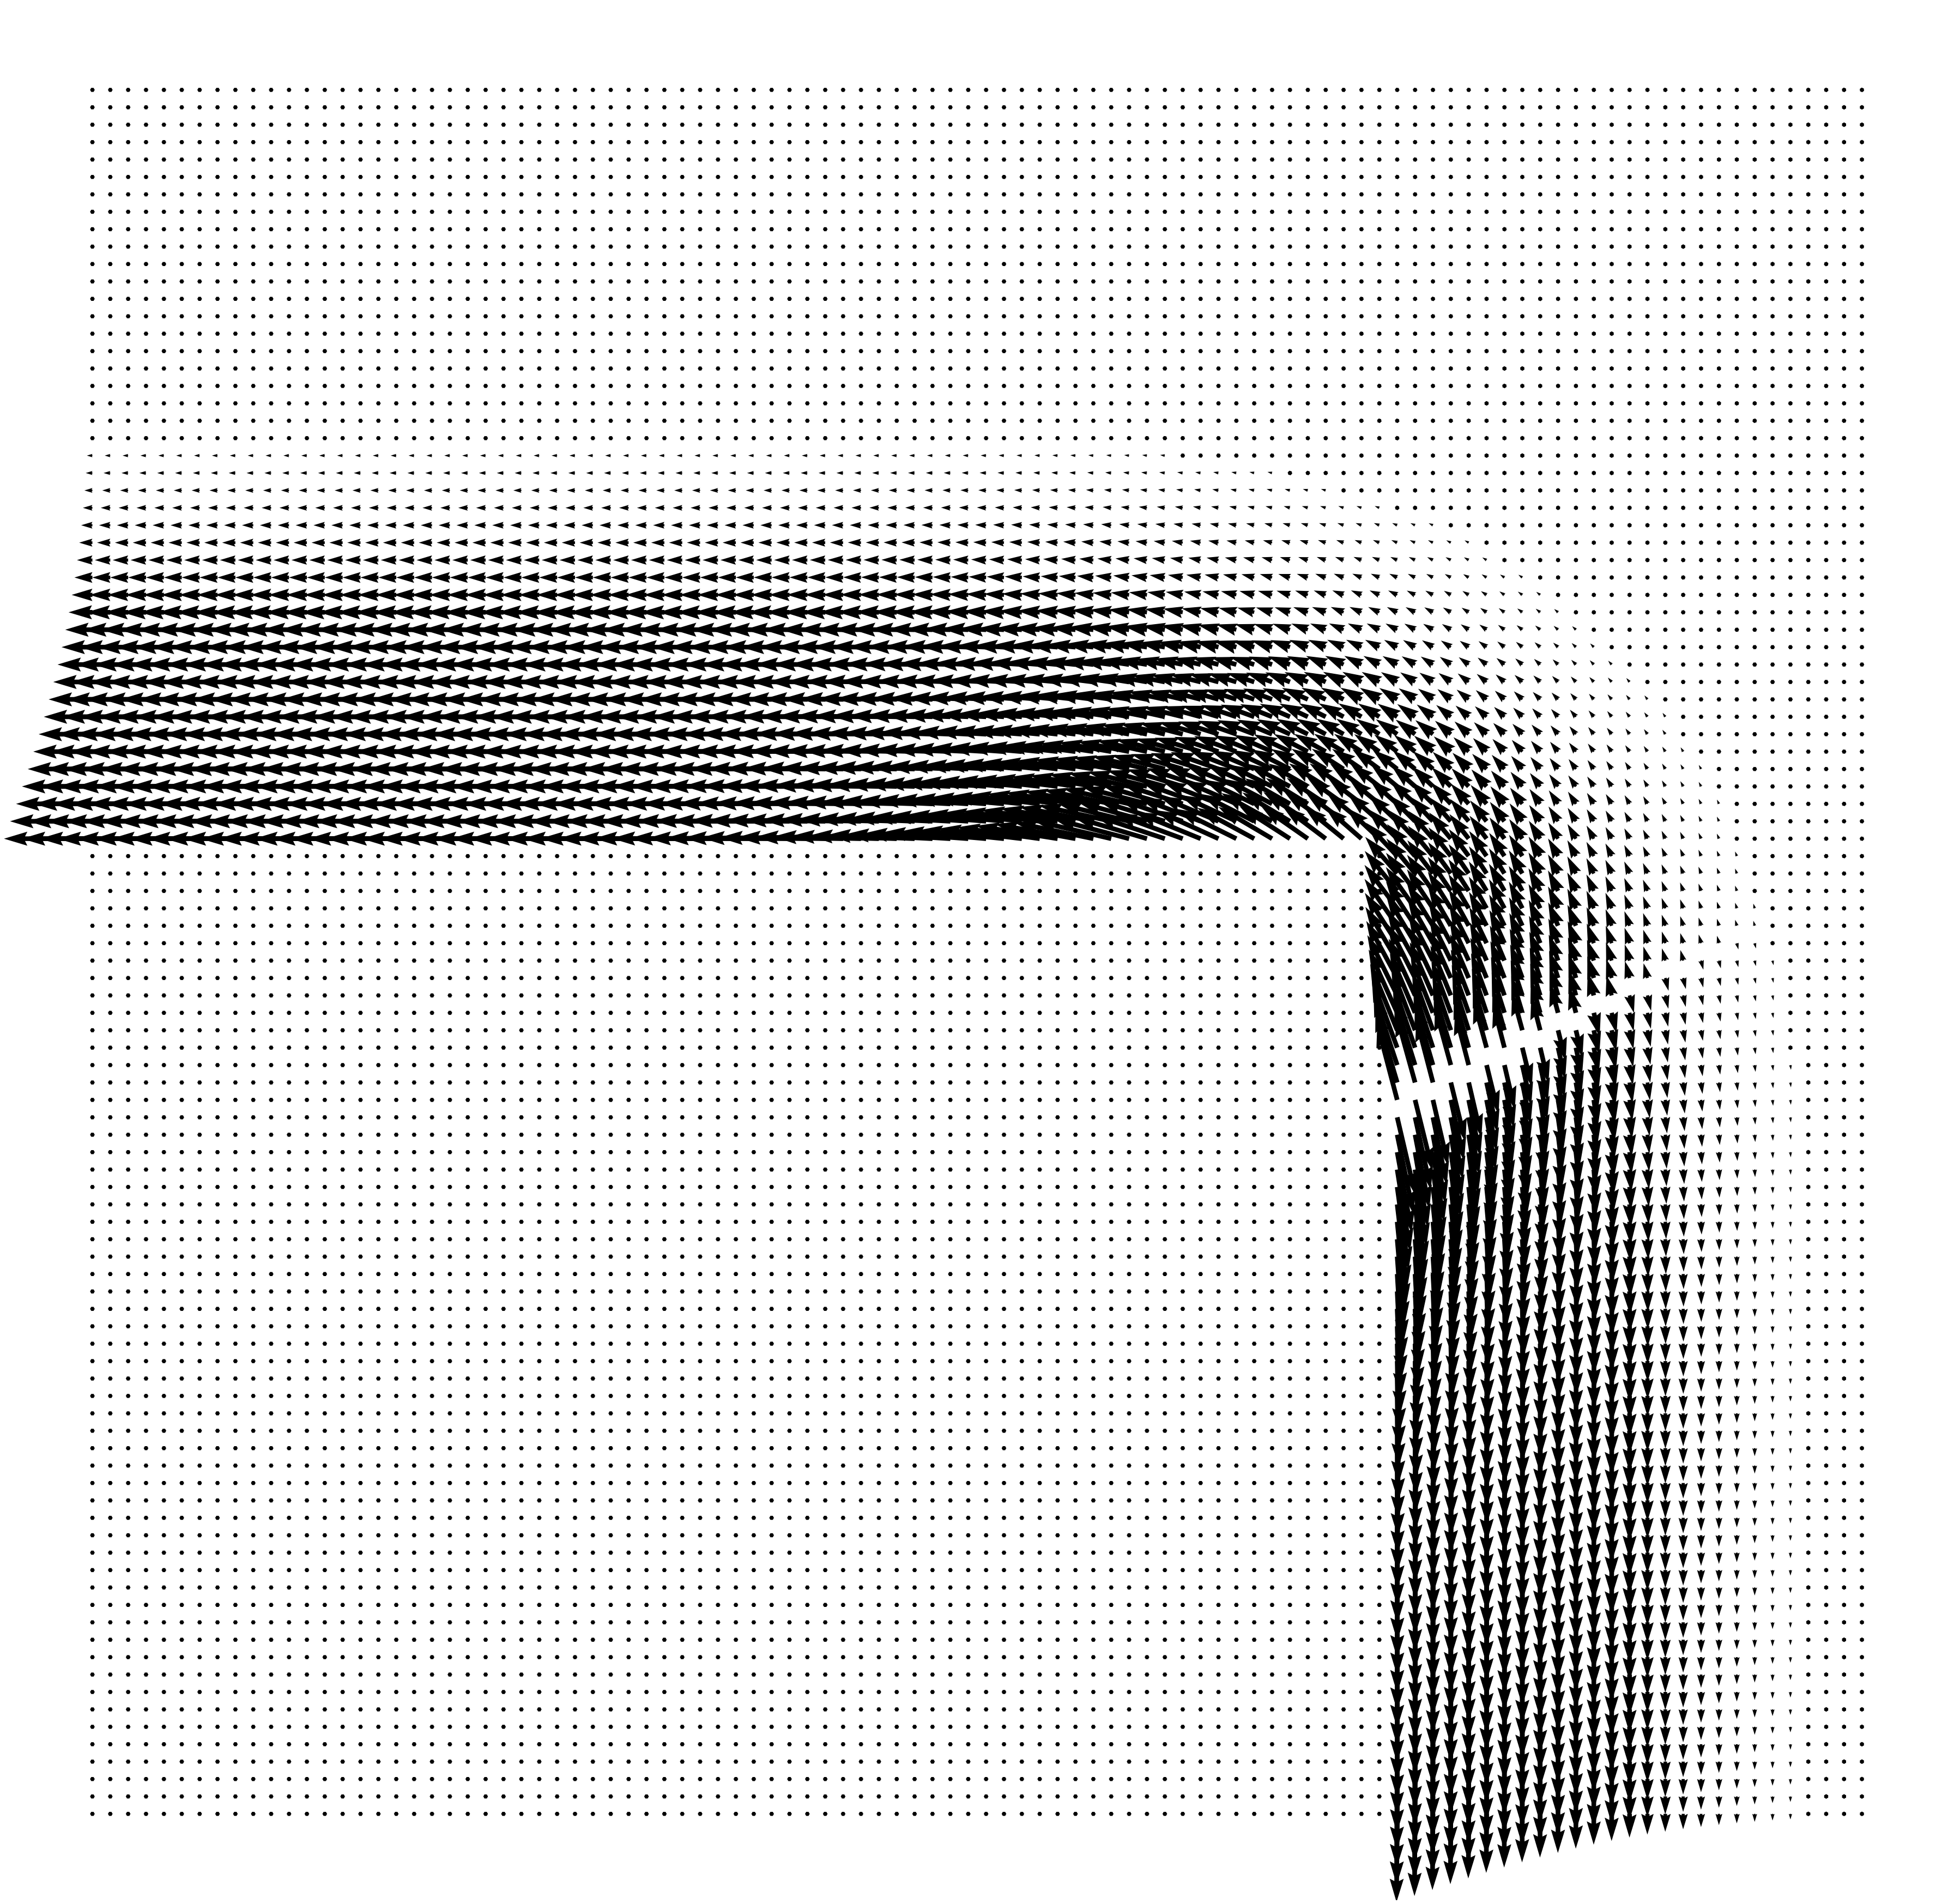

In [48]:
center = (425,50)
lim = 50
plt.figure(figsize=(64,64))
plt.quiver(crop(x,center,lim), crop(y,center,lim)[::-1], crop(field[:,:,0], center, lim), crop(field[:,:,1], center, lim))
plt.axis('off')
# plt.imshow(crop(img, center, lim))
plt.show()

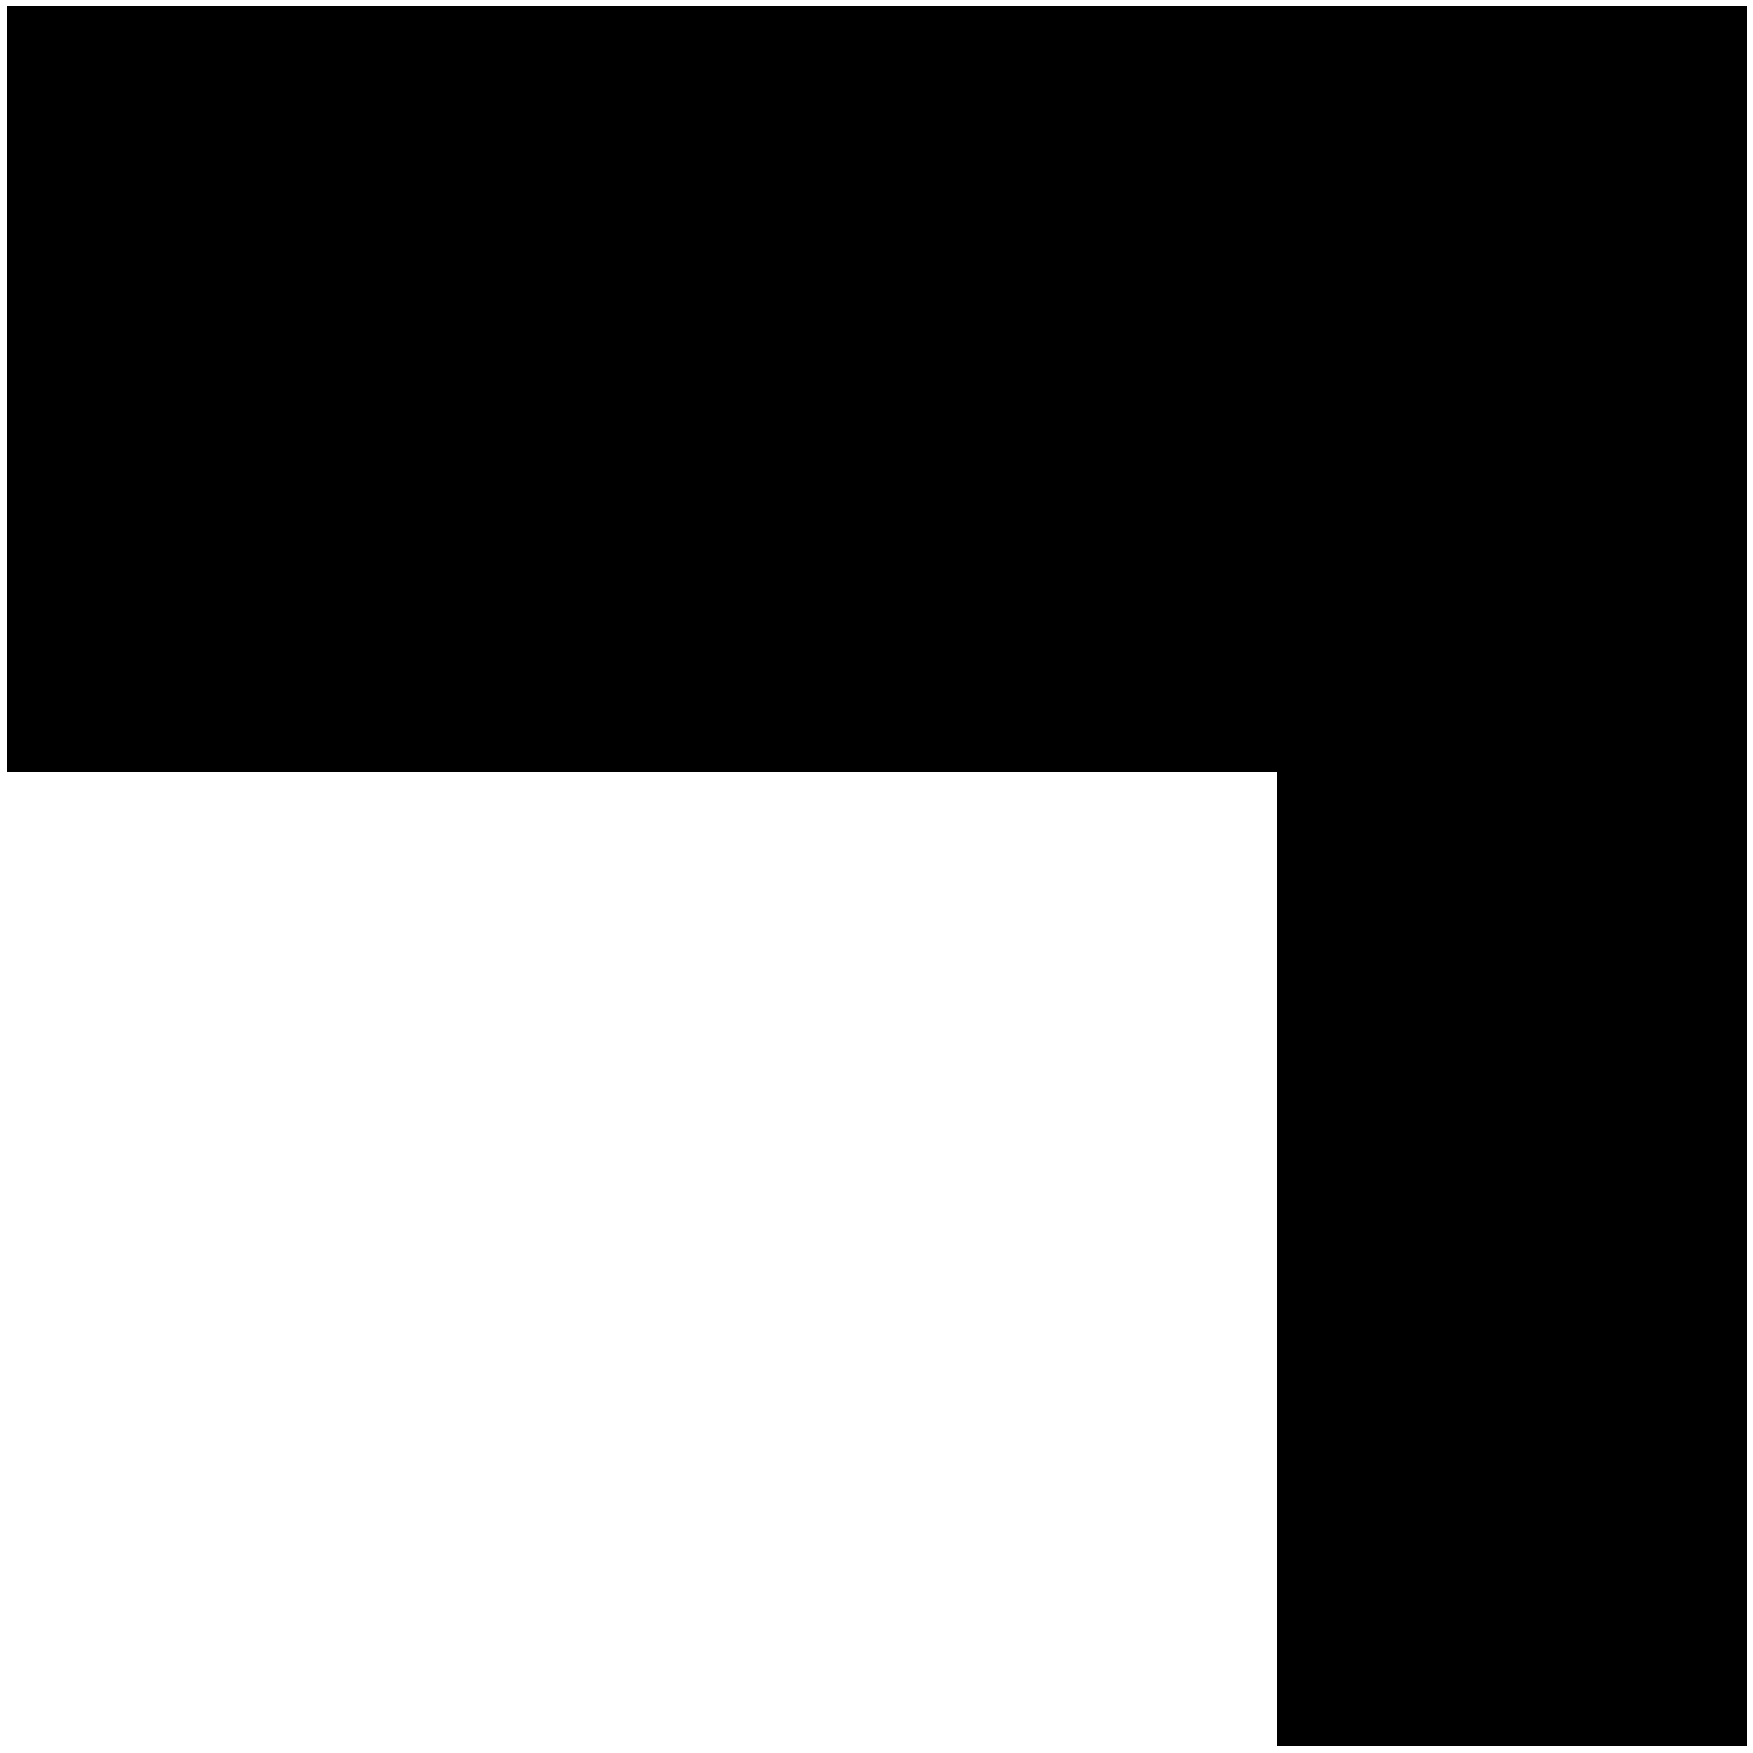

In [49]:
display_image(crop(img, center, lim))

In [50]:
write_field_file(field, '../src/assets/maps/basic/map.ts')

TypeError: write_field_file() missing 1 required positional argument: 'buildings'